In [22]:
import subprocess
import sys
import os
import argparse
import glob
from pathlib import Path
import json
import time
import bilby
import nmma

import astropy
import numpy as np
import pandas as pd

from astropy.time import Time

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nmma.em.model import SimpleKilonovaLightCurveModel,GRBLightCurveModel, SVDLightCurveModel, KilonovaGRBLightCurveModel, GenericCombineLightCurveModel, SupernovaLightCurveModel, ShockCoolingLightCurveModel

from nmma.em.injection import create_light_curve_data as cld

snModel = lambda t: SupernovaLightCurveModel(sample_times=t, model='nugent-hyper')
grbModel = lambda t: GRBLightCurveModel(sample_times=t, model='TrPi2018')
knModel = lambda t: SVDLightCurveModel(sample_times=t, model='Bu2019lm')

Install afterglowpy if you want to timeout simulations.


In [3]:
modelDict = lambda t: {'nugent-hyper':snModel(t), 'TrPi2018':grbModel(t), 'Bu2019lm':knModel(t)}
print(modelDict([1])['nugent-hyper'])

/home/tyler/anaconda3/envs/nmma/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


SupernovaLightCurveModel(model={self.model})


In [4]:
# modelDict([1])['Bu2019lm'].generate_lightcurve(sample_times=np.array([1]), parameters=best_params)

In [5]:
def luminosity(distance, mag):
    """
    Calculate the luminosity of a source given its distance and apparent magnitude.
    Parameters
    """
    abs = lambda mag, distance: mag - 5 * np.log10(distance * 1e6 / 10.0)
    if type(mag) == np.ndarray:
        return abs(mag, distance)
    elif type(mag) == dict:
        return {k: abs(mag[k], distance) for k in mag.keys()} 

def read_json(path_to_file):
    with open(path_to_file) as p:
        return json.load(p, object_hook=bilby.core.utils.decode_bilby_json)

In [6]:
results = glob.glob('./fits/*/*result.json')
print("Found {} results".format(len(results)))
print()

Found 189 results



In [7]:
root_directory = Path('./fits/')
total_size = sum(f.stat().st_size for f in root_directory.glob('**/*') if f.is_file()) / 1024**3
print("Total size: {:.2f} GB".format(total_size))
json_size = sum(f.stat().st_size for f in root_directory.glob('**/*result.json') if f.is_file()) / 1024**3
print("JSON size: {:.2f} GB".format(json_size))
print('json files occupy {:.2f}% of the total size'.format(json_size / total_size * 100))

Total size: 2.32 GB
JSON size: 0.75 GB
json files occupy 32.42% of the total size


In [8]:
start = time.time()
jsons = [read_json(f) for f in results]
stop = time.time()
print("Reading {} json files took {:.2f} seconds \n(average {:.2f} sec/file)".format(len(jsons), stop - start, (stop - start) / len(jsons)))

Reading 189 json files took 11.66 seconds 
(average 0.06 sec/file)


In [9]:
jsons[0]['label'].split('_')[0] + '_' + jsons[0]['label'].split('_')[1] + '_' + jsons[0]['label'].split('_')[-2] + '_' + jsons[0]['label'].split('_')[-1]
jsons[0]['label'].split('_')[3] 

'Bu2019lm'

In [10]:
posterior_samples = [j['posterior'] for j in jsons]

In [11]:
ll_idx = np.argmin(np.abs(jsons[0]['log_likelihood_evaluations']))
print("Best log likelihood evaluation: {}".format(ll_idx))
print(jsons[0]['log_likelihood_evaluations'][ll_idx])
print(jsons[0]['samples'][ll_idx])
best_params = dict(zip(jsons[0]['search_parameter_keys'], jsons[0]['samples'][ll_idx]))
display(best_params)

Best log likelihood evaluation: 7906
-21.183629314906504
[ 9.48264161 49.1045723   0.77937232 -1.93927027 -2.50605828 -1.32867461
  0.16131121]


{'luminosity_distance': 9.482641609762611,
 'KNphi': 49.10457230173926,
 'inclination_EM': 0.7793723226107803,
 'KNtimeshift': -1.9392702697004678,
 'log10_mej_dyn': -2.5060582838342813,
 'log10_mej_wind': -1.3286746136344751,
 'Ebv': 0.16131120572259705}

In [12]:
def get_lc(file, tmax=False):
    '''imports dat file as a pandas dataframe'''
    df = pd.read_csv(file, sep=' ', header=None, names=['t', 'filter', 'mag', 'mag_unc'])
    df = df[df['mag_unc'] != np.inf] ## drop non-detections
    df['t'] = Time(pd.to_datetime(df['t'])).mjd ## convert to mjd
    df['t'] = df['t'] - df['t'].min() ## set t=0 to first observation
    if tmax:
        df = df[df['t'] < tmax]
    return df

In [13]:
get_lc('./injection_sample/lc_Bu2019lm_0.dat')

,t,filter,mag,mag_unc
0,0.000000,g,12.364482,0.022590
1,1.960209,g,12.654026,0.058831
2,3.946964,g,14.291193,0.039201
3,5.926730,g,15.711854,0.025181
4,8.921960,g,17.933233,0.016180
5,11.921213,g,20.109354,0.147486


In [14]:
def get_best_params(json, verbose=False):
    '''Get the best fit parameters from a bilby json file, return as a dictionary'''
    # ll_idx = np.argmin(np.abs(json['log_likelihood_evaluations']))
    #best_ll = json['log_likelihood_evaluations'][ll_idx]
    post = json['posterior']
    ll_idx = np.argmin(np.abs(post['log_likelihood']))
    best_ll = post['log_likelihood'][ll_idx]
    post_keys = list(post.keys())
    print("Best log likelihood evaluation: {}".format(best_ll)) if verbose else None
    log_evidence = json['log_evidence']
    log_evidence_err = json['log_evidence_err']
    log_bayes_factor = json['log_bayes_factor']
    likelihood_dict = dict(zip(['log_likelihood','log_evidence', 'log_evidence_err', 'log_bayes_factor'], [best_ll, log_evidence, log_evidence_err, log_bayes_factor]))
    # print(bp_dict) if verbose else None
    #bp_dict = dict(zip(json['search_parameter_keys'], json['samples'][ll_idx]))
    # bp_dict = dict(zip(json['search_parameter_keys'], json['samples'][ll_idx, :]))
    bp_dict = dict(zip(post_keys, [post[k][ll_idx] for k in post_keys]))

    return bp_dict, likelihood_dict

def get_labels(json):
    '''get the object label from bilby file, return as a dictionary'''
    raw_label = json['label']
    candidate = raw_label.split('_')[0] + '_' + raw_label.split('_')[1]
    model = raw_label.split('_')[3]
    tmax = float(raw_label.split('_')[5])
    keys = ['candidate', 'model', 'tmax']
    label_dict = dict(zip(keys, [candidate, model, tmax]))
    
    return label_dict

In [15]:
def gen_lc(json, model, sample_times, verbose=False):
    '''Generate a light curve from a bilby json file'''
    bp, like_dict = get_best_params(json, verbose=verbose)
    model_type = get_labels(json)['model']
    model = modelDict(sample_times)[model_type]
    print(model) if verbose else None
    label = get_labels(json)
    print(label) if verbose else None
    print(bp) 
    print()
    lc = model.generate_lightcurve(sample_times, parameters=bp)[1]
    lc_abs = luminosity(bp['luminosity_distance'], lc)
    return lc_abs, label

def calc_resids(lc, data):
    '''Calculate residuals between a light curve and data'''
    # assert len(lc) == len(data):
    resids = 0
    for filter in data['filter'].unique():
        t_sample = data[data['filter'] == filter]['t']
        lc_filt = lc[filter] #gen_lc(json, modelDict(t_sample)['Bu2019lm'], t_sample)[1]
        data_filt = data[data['filter'] == filter]
        resids += np.sum(np.abs(lc_filt - data_filt['mag']))/ data_filt['mag_unc']/len(lc_filt)
    return resids


In [16]:
def create_series(json, residuals=False):
    '''creates a pandas series from a bilby json file (already read in)'''
    label_dict = get_labels(json)
    bp_dict, likelihood_dict = get_best_params(json)
    obj_dict = {**label_dict,  **likelihood_dict, **bp_dict,}
    obj_series = pd.Series(obj_dict)
    
    if residuals:
        # print(bp_dict)
        tmax = label_dict['tmax']
        data = get_lc('./injection_sample/lc_{}.dat'.format(label_dict['candidate']),
                      tmax=tmax) ## should be a function argument
        t_sample = np.array(data['t'])
        # print(type(t_sample))
        model = modelDict(t_sample)[label_dict['model']]
        print("json file: {}".format(json['label']))
        print("model: {}".format(model))
        # if model == GRBLightCurveModel(model='TrPi2018', sample_times=t_sample):
        #     print(json['log10_E0'])
        
        bf_lc, _ = gen_lc(json, model, t_sample)
        resids = calc_resids(bf_lc, data)
        obj_series['residuals'] = resids
    return obj_series

def create_df(jsons, residuals=False):
    '''creates a pandas dataframe from a list of bilby json files (already read in)'''
    return pd.DataFrame([create_series(j, residuals) for j in jsons]).sort_values(by=['candidate','model','tmax']).reset_index(drop=True)


In [17]:
# import warnings
# warnings.simplefilter("ignore", UserWarning)
# t0 = time.time()
# df = create_df(jsons, residuals=False)
# t1 = time.time()
# print("Creating dataframe (no residuals) took {:.2f} seconds".format(t1-t0))
# df.to_csv('fit_results.csv', index=False)

# t0 = time.time()
# df = create_df(jsons, residuals=True)
# t1 = time.time()
# print("Creating dataframe (with residuals) took {:.2f} seconds".format(t1-t0))
# df.to_csv('fit_results_residuals.csv', index=False)
# display(df.head())

In [18]:
# log_likelihood_test = ([read_json(j) for j in glob.glob('./fits/Bu2019lm_0_fit_Bu2019lm/*result.json')])

# sorted_idx = np.argsort([j['label'] for j in log_likelihood_test])
# log_likelihood_test = [log_likelihood_test[i] for i in sorted_idx]
# display([j['label'] for j in log_likelihood_test])

# [np.min(j['log_likelihood_evaluations']) for j in log_likelihood_test]

In [53]:
df = pd.read_csv('fit_results_residuals.csv')
display(df)

,candidate,model,tmax,log_likelihood,log_evidence,log_evidence_err,log_bayes_factor,luminosity_distance,KNphi,inclination_EM,...,log10_E0,thetaCore,thetaWing,ksiN,L0,dL,b,q,ts,supernova_mag_boost
0,Bu2019lm_0,Bu2019lm,3.0,-1.839964,-4.449230,0.038426,-4.449230,3.295906,30.549275,0.696123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bu2019lm_0,Bu2019lm,5.0,-2.762334,-5.892161,0.044352,-5.892161,4.075219,15.447818,0.720362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bu2019lm_0,Bu2019lm,7.0,-3.702193,-7.097867,0.047615,-7.097867,3.648042,34.723325,0.636170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bu2019lm_0,Bu2019lm,9.0,-3.680391,-7.065270,0.047468,-7.065270,3.433203,21.862424,0.044639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bu2019lm_0,Bu2019lm,11.0,-4.613381,-8.334442,0.050026,-8.334442,2.620773,38.605429,0.525655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,nugent-hyper_6,nugent-hyper,7.0,-3.683588,-5.870950,0.039948,-5.870950,242.344982,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024119
185,nugent-hyper_6,nugent-hyper,9.0,-3.683424,-5.893540,0.040206,-5.893540,285.961851,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.595624
186,nugent-hyper_6,nugent-hyper,11.0,-4.602449,-6.924065,0.041556,-6.924065,265.856471,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.407122
187,nugent-hyper_6,nugent-hyper,13.0,-5.522398,-7.954438,0.042642,-7.954438,277.180745,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.059438


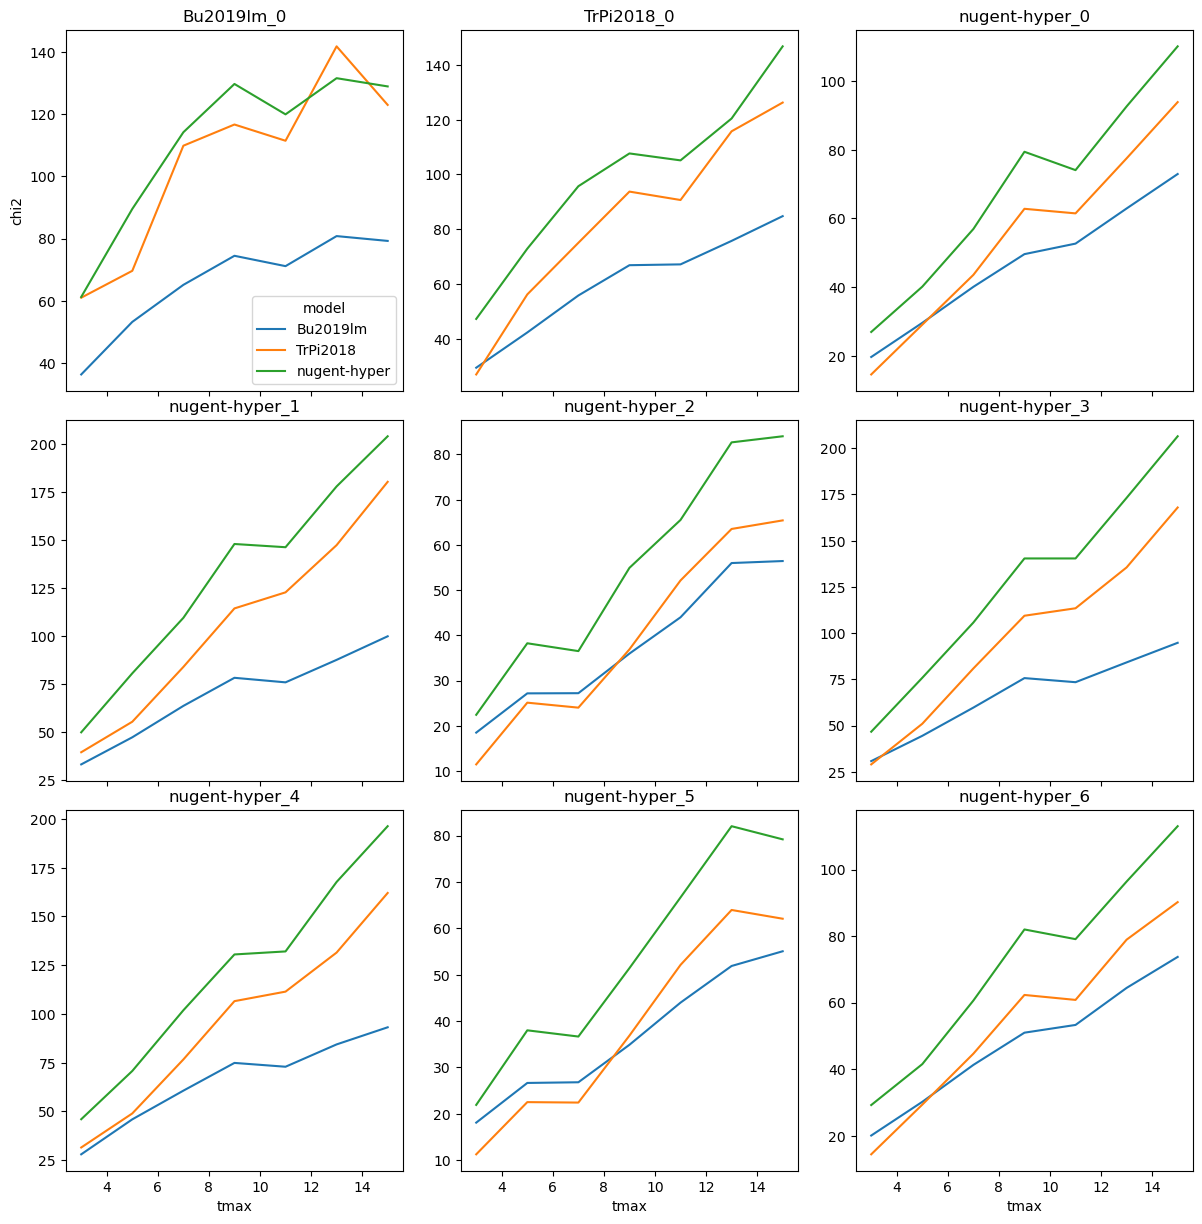

In [54]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharex=True, facecolor='w', edgecolor='k')
fig.tight_layout()
axs = axs.flatten()

objects = df['candidate'].unique()

for idx, obj in enumerate(objects):
    obj_df = df[df['candidate'] == obj]
    obj_df = obj_df.sort_values(by=['model','tmax'])
    sns.lineplot(x='tmax', y=obj_df['chi2'], hue='model', data=obj_df, ax=axs[idx])
    # axs[idx].plot(obj_df['tmax'], obj_df['residuals'], 'o')
    axs[idx].set_title(obj)
    axs[idx].set_xlabel('tmax')
    #axs[idx].set_ylabel('residuals')
    if idx != 0:
        axs[idx].legend().set_visible(False)
        axs[idx].set_ylabel('')
    # axs[idx].set_yscale('log')

plt.show()